In [1]:
pip install scikit-learn-extra

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

In [4]:
df=pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Customer Analytics/supermarket.csv')

df.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200734,20071019,6,8,1,9.50,PRD0901335,CL00058,DEP00016,G00006,...,XX,OT,994108000679877,M,MM,Small Shop,Fresh,STORE00001,LS,E02
1,200805,20080328,6,21,1,1.49,PRD0901120,CL00162,DEP00055,G00016,...,XX,NaN,994110300629787,S,MM,Small Shop,Fresh,STORE00001,LS,E02
2,200716,20070612,3,9,1,0.86,PRD0900963,CL00248,DEP00089,G00030,...,NaN,NaN,994106200026009,S,MM,Small Shop,Grocery,STORE00001,LS,E02
3,200815,20080604,4,10,3,0.90,PRD0901055,CL00248,DEP00089,G00030,...,NaN,NaN,994111300076346,L,MM,Top Up,Grocery,STORE00001,LS,E02
4,200626,20060824,5,16,1,1.77,PRD0901877,CL00169,DEP00056,G00017,...,NaN,NaN,994102000065854,L,LA,Top Up,Fresh,STORE00001,LS,E02


Select only transaction has Customer Code

In [5]:
df=df[df['CUST_CODE'] != "NaN"]

# Features

Total Spend by Customer Code

In [6]:
features=df.groupby('CUST_CODE')['SPEND'].sum().reset_index()

Purchase Frequency

In [7]:
#Frequency
features['frequency']=list(df.groupby('CUST_CODE')['BASKET_ID'].nunique())

#Total time
features['startdate']=list(df.groupby('CUST_CODE')['SHOP_DATE'].min())
features['startdate']=features['startdate'].astype(str).apply(lambda x: datetime.strptime(x, "%Y%m%d").date())

features['lastdate']=list(df.groupby('CUST_CODE')['SHOP_DATE'].max())
features['lastdate']=features['lastdate'].astype(str).apply(lambda x: datetime.strptime(x, "%Y%m%d").date())

features['total_time']=((features['lastdate']-features['startdate']).dt.days)+1

In [8]:
#MEAN TIME BETAWEEN PURCHASE
features['mtbp']=features['total_time']/features['frequency']

#LIFETIME
features['lifetime']=(datetime.strptime(str(df['SHOP_DATE'].max()), "%Y%m%d").date()-features['startdate']).dt.days

#Average Usage per User
arpu=features['SPEND'].sum()/features['CUST_CODE'].nunique()

#CLTV
features['cltv']=features['lifetime']*arpu

#AVERAGE SPEND
#features = features.merge(df.groupby('CUST_CODE')['BASKET_ID'].nunique().reset_index(), on='CUST_CODE', how='left')
features['avg_bskt_spend']=features['SPEND']/features['frequency']

features

,CUST_CODE,SPEND,frequency,startdate,lastdate,total_time,mtbp,lifetime,cltv,avg_bskt_spend
0,CUST0000000181,2.44,1,2007-01-06,2007-01-06,1,1.000000,547,151020.342457,2.440000
1,CUST0000000689,328.57,16,2007-07-22,2008-06-23,338,21.125000,350,96630.932102,20.535625
2,CUST0000000998,5.95,3,2006-05-04,2006-07-07,65,21.666667,794,219214.171684,1.983333
3,CUST0000001163,39.74,4,2006-10-22,2008-06-22,610,152.500000,623,172003.059142,9.935000
4,CUST0000001194,2493.83,103,2006-04-22,2008-06-20,791,7.679612,806,222527.232213,24.211942
...,...,...,...,...,...,...,...,...,...,...
3434,CUST0000999439,43.60,10,2006-05-28,2008-07-05,770,77.000000,770,212588.050625,4.360000
3435,CUST0000999544,6.32,1,2007-03-23,2007-03-23,1,1.000000,471,130037.625772,6.320000
3436,CUST0000999593,453.58,30,2006-05-06,2008-04-02,698,23.266667,792,218661.994929,15.119333
3437,CUST0000999935,444.17,21,2006-11-29,2008-06-05,555,26.428571,585,161511.700800,21.150952


In [9]:
#Customer price sensitivity
s=df.iloc[:,11:13].drop_duplicates(subset='CUST_CODE').dropna().sort_values(by='CUST_CODE').reset_index(drop=True)

features=pd.concat([features, s['CUST_PRICE_SENSITIVITY']], axis=1)

#One Hot Encoding on Customer price sensitivity
one_hot_encoded = pd.get_dummies(features['CUST_PRICE_SENSITIVITY'], prefix='PRICE_SENSITIVITY')
features = pd.concat([features, one_hot_encoded], axis=1)


In [10]:
#Customer Lifestage
a=pd.concat([df['CUST_CODE'], df['CUST_LIFESTAGE']], axis=1).drop_duplicates(subset='CUST_CODE').dropna(subset=['CUST_CODE']).sort_values(by='CUST_CODE').reset_index(drop=True)

features=pd.concat([features, a['CUST_LIFESTAGE']], axis=1)

#One Hot Encoding on CUST_LIFESTAGE
one_hot_encoded = pd.get_dummies(features['CUST_LIFESTAGE'], prefix='LIFESTAGE')
features = pd.concat([features, one_hot_encoded], axis=1)

In [11]:
features=features.drop(['CUST_LIFESTAGE'], axis=1)

# Customer Segmentation

In [12]:
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [13]:
# Create a sample DataFrame with multiple features
seg=pd.concat([features.iloc[:,1:3],features.iloc[:,5:]], axis=1)

In [14]:
seg=seg.drop(columns=['CUST_PRICE_SENSITIVITY'])

In [15]:
# Standardize the features
#scaler = StandardScaler()
#seg_scaled = scaler.fit_transform(seg)

In [16]:
# def normal distribution test
def normality_test(df):
    from scipy.stats import shapiro
    for col in df.columns:
        stat, p = shapiro(df[col]) # shapiro test
        if p <= 0.05:
            print(f'===== {col} =====')
            print('Statistics=%.3f, p=%.3f' % (stat, p))
            print('Probably not Gaussian')

def distribution_plot(df):
    num_cols = len(df.columns)
    num_rows = (num_cols + 3) // 4  # Calculate the number of rows based on the number of columns

    fig, ax = plt.subplots(num_rows, 4, figsize=(20, 5*num_rows))
    for i, col in enumerate(df.columns):
        sns.distplot(df[col], ax=ax[i//4, i%4])
        ax[i//4, i%4].set_title(col)

    # Remove any unused subplots
    if num_cols < num_rows * 4:
        for j in range(num_cols % 4, 4):
            fig.delaxes(ax[num_rows-1, j])
    plt.tight_layout()
    plt.show()

*** Normality - Before transform ***
===== SPEND =====
Statistics=0.423, p=0.000
Probably not Gaussian
===== frequency =====
Statistics=0.418, p=0.000
Probably not Gaussian
===== total_time =====
Statistics=0.831, p=0.000
Probably not Gaussian
===== mtbp =====
Statistics=0.725, p=0.000
Probably not Gaussian
===== lifetime =====
Statistics=0.901, p=0.000
Probably not Gaussian
===== cltv =====
Statistics=0.901, p=0.000
Probably not Gaussian
===== avg_bskt_spend =====
Statistics=0.694, p=0.000
Probably not Gaussian
===== PRICE_SENSITIVITY_LA =====
Statistics=0.564, p=0.000
Probably not Gaussian
===== PRICE_SENSITIVITY_MM =====
Statistics=0.624, p=0.000
Probably not Gaussian
===== PRICE_SENSITIVITY_UM =====
Statistics=0.554, p=0.000
Probably not Gaussian
===== PRICE_SENSITIVITY_XX =====
Statistics=0.191, p=0.000
Probably not Gaussian
===== LIFESTAGE_OA =====
Statistics=0.377, p=0.000
Probably not Gaussian
===== LIFESTAGE_OF =====
Statistics=0.240, p=0.000
Probably not Gaussian
===== LIFEST

<ipython-input-16-fcae97f78da7>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[i//4, i%4])
<ipython-input-16-fcae97f78da7>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[i//4, i%4])
<ipython-input-16-fcae97f78da7>:17: UserWarning: 

`distplot` is a deprecated 

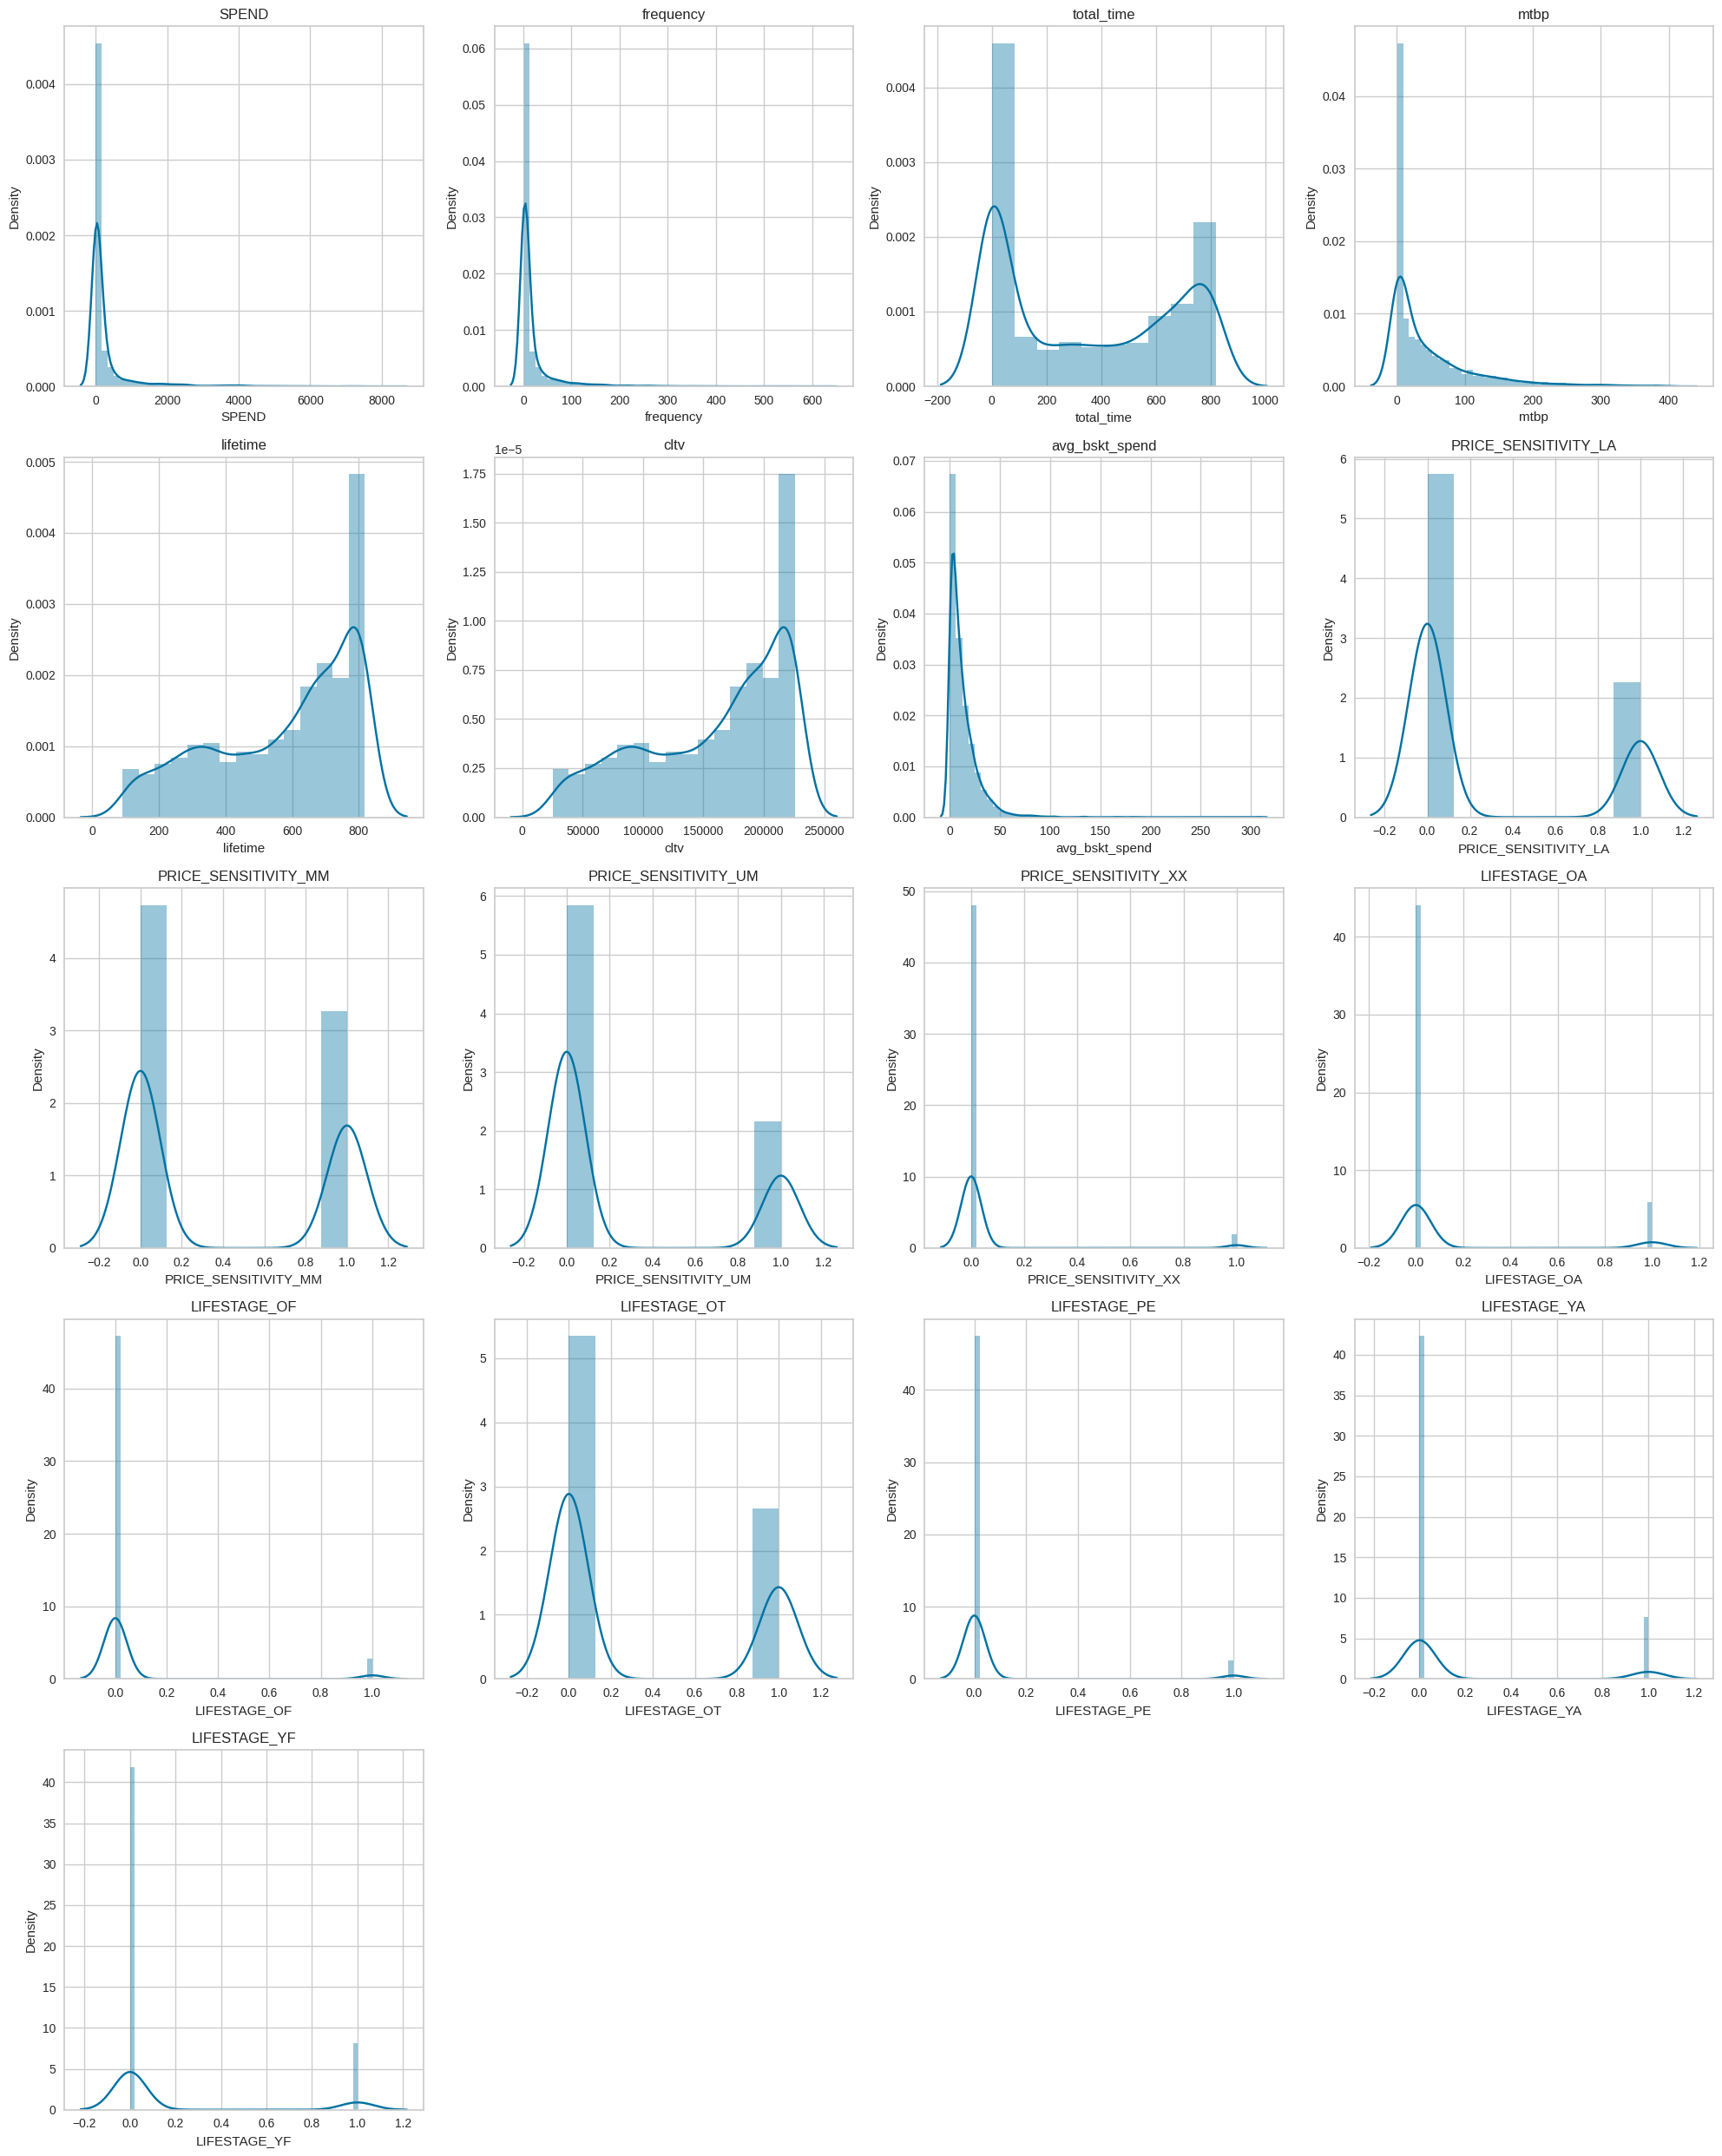

In [17]:
print('*** Normality - Before transform ***')
normality_test(seg)
distribution_plot(seg)

*** Normality - After transform ***


<ipython-input-16-fcae97f78da7>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[i//4, i%4])
<ipython-input-16-fcae97f78da7>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[i//4, i%4])
<ipython-input-16-fcae97f78da7>:17: UserWarning: 

`distplot` is a deprecated 

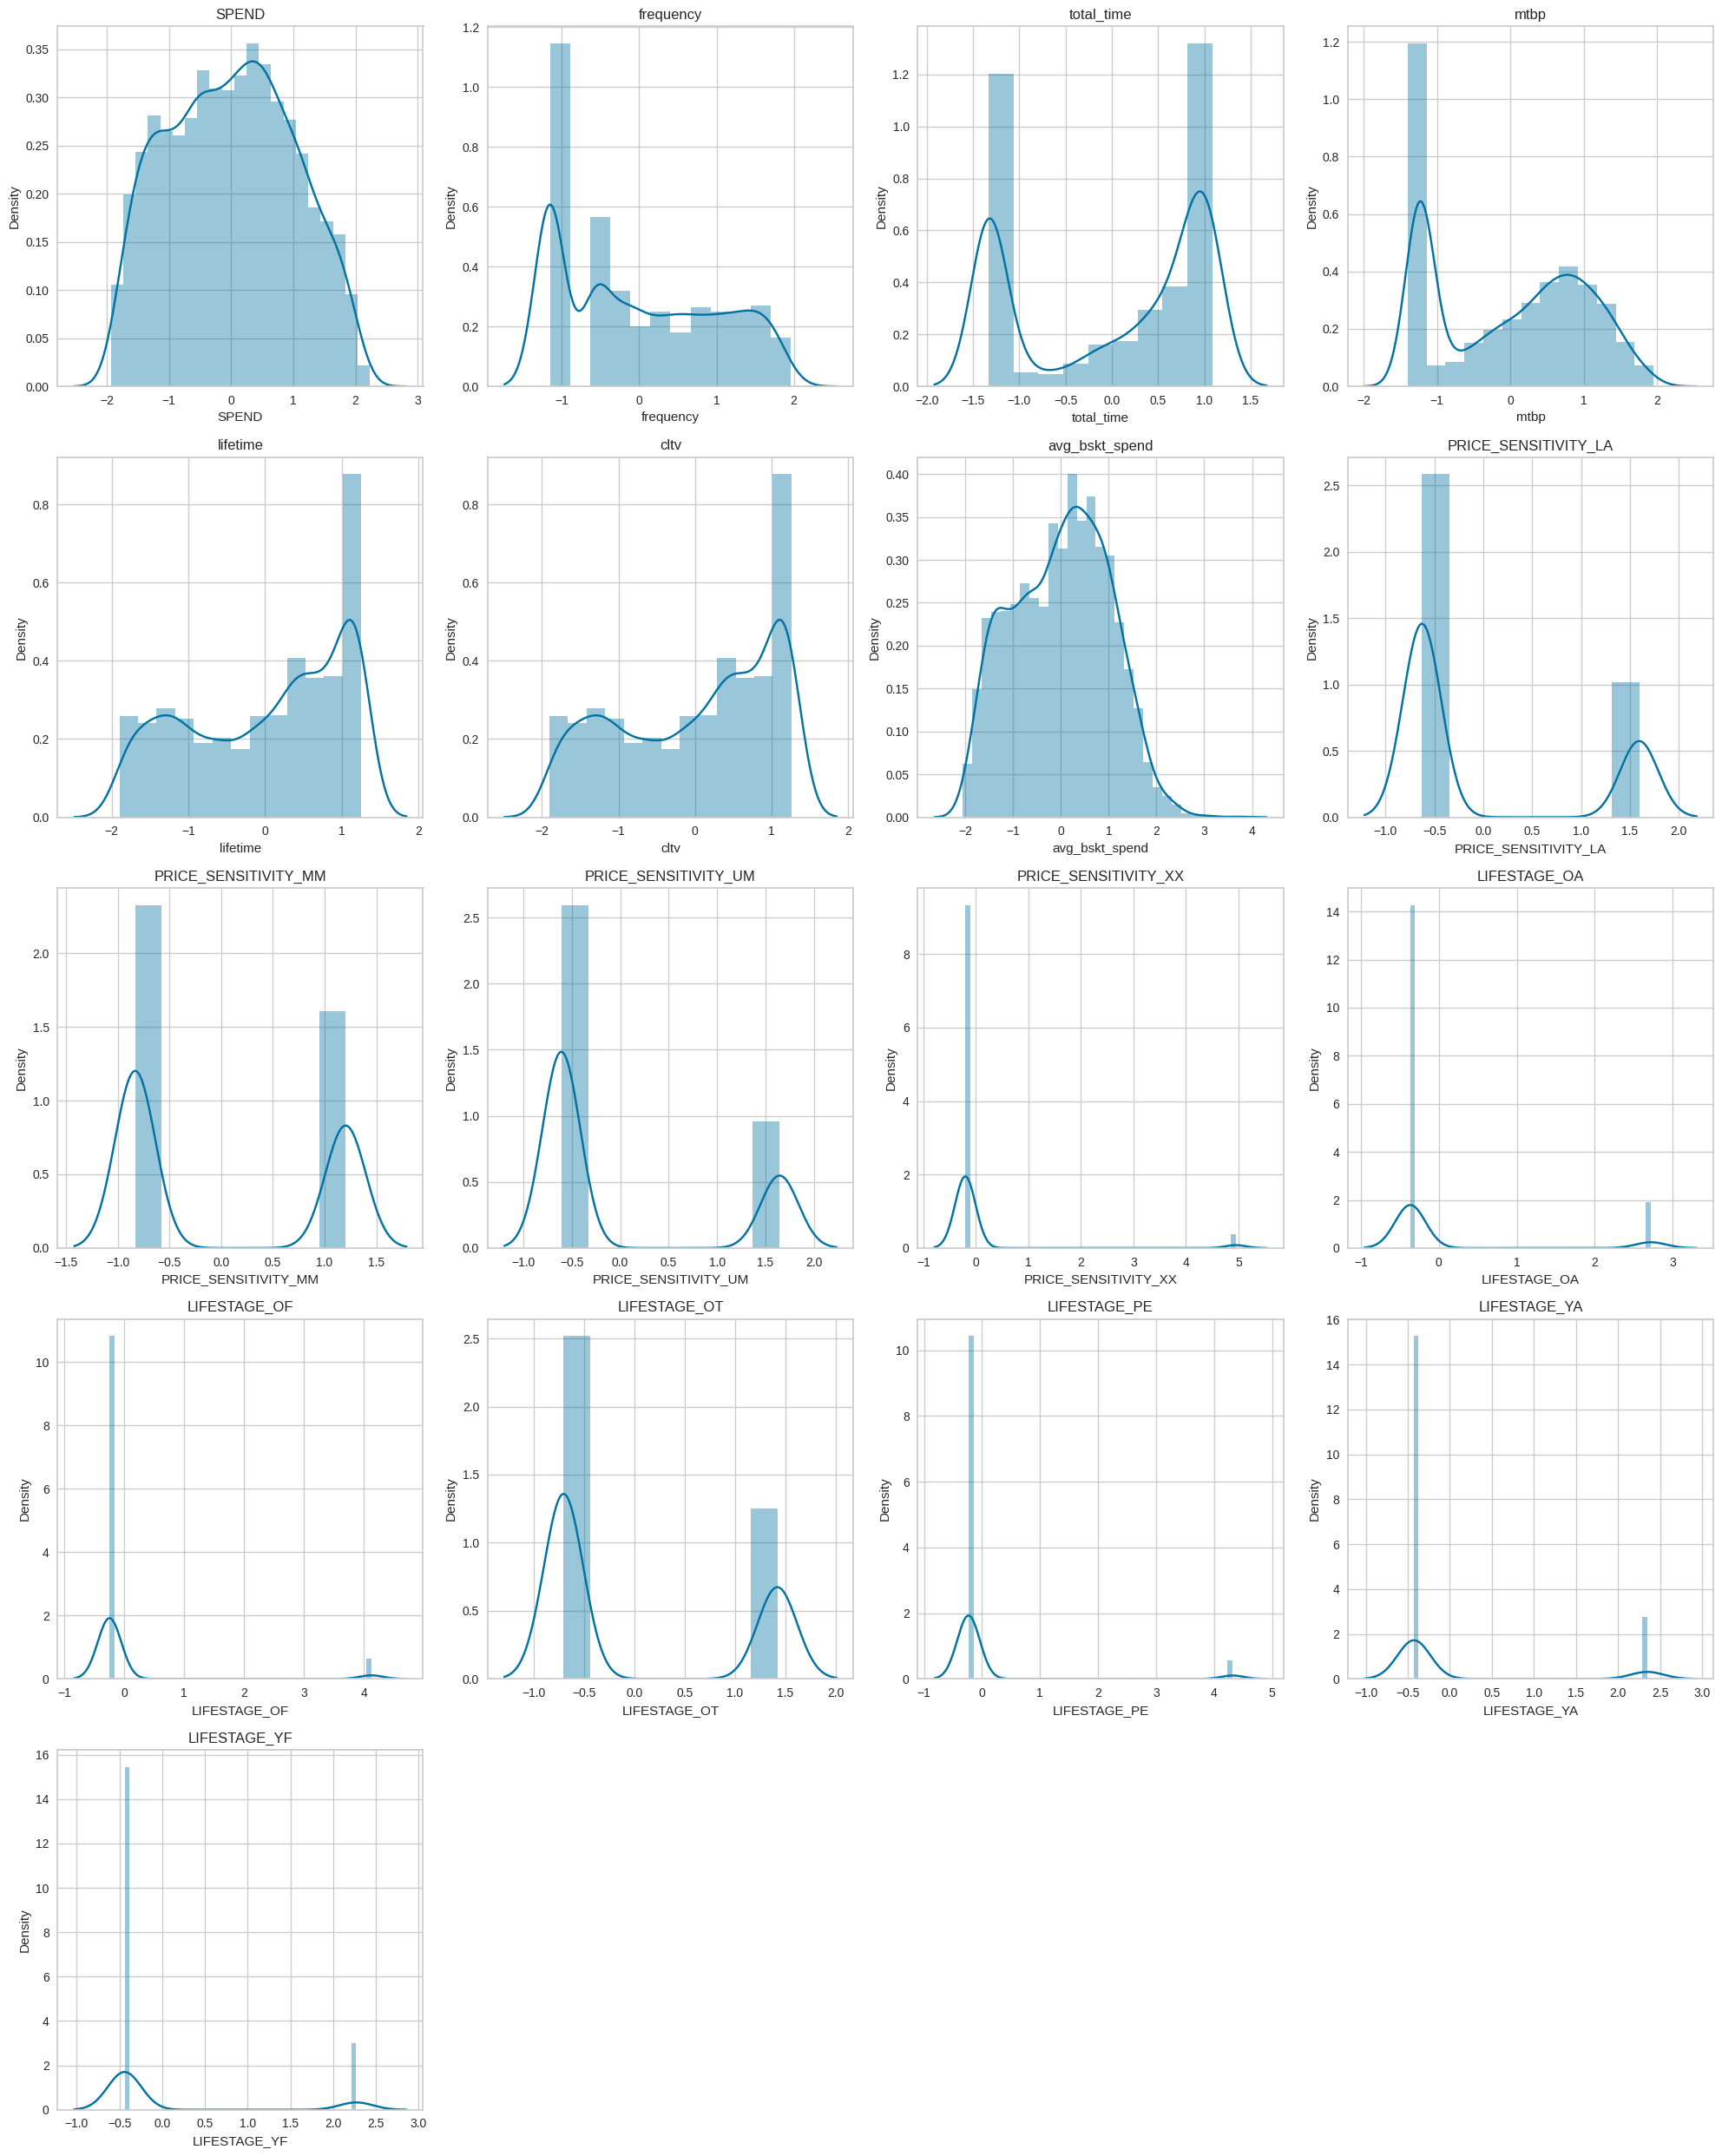

In [18]:
# power transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer() #default=’yeo-johnson’
seg_scaled = pd.DataFrame(pt.fit_transform(seg))
seg_scaled.columns = seg.columns

print('*** Normality - After transform ***')
#normality_test(seg_transform)
distribution_plot(seg_scaled)

Elbow Method to determine the number of clusters to be formed:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

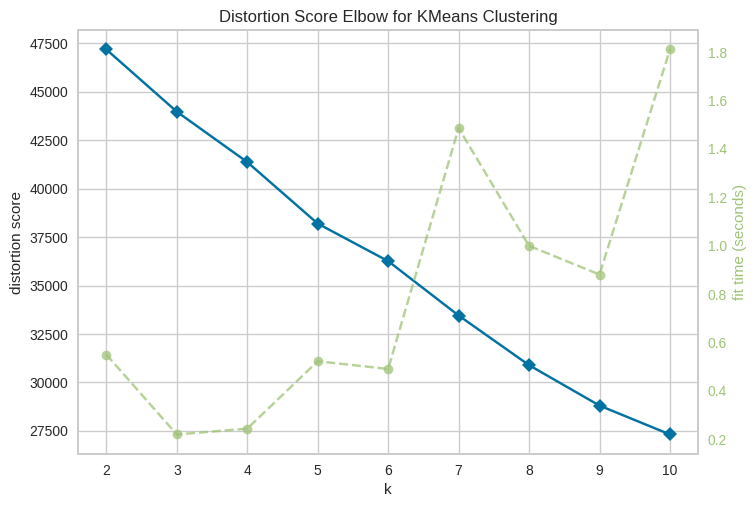

In [19]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=158), k=10, scoere='calinski_harabasz')
Elbow_M.fit(seg_scaled)
Elbow_M.show();

For n_clusters = 2 The average silhouette_score is: 0.18779924896799696
For n_clusters = 3 The average silhouette_score is: 0.11723065156164328
For n_clusters = 4 The average silhouette_score is: 0.1098232970402224
For n_clusters = 5 The average silhouette_score is: 0.15225901437141368
For n_clusters = 6 The average silhouette_score is: 0.14026179711504078
For n_clusters = 7 The average silhouette_score is: 0.1710265315334975
For n_clusters = 8 The average silhouette_score is: 0.19083267482178867
For n_clusters = 9 The average silhouette_score is: 0.20616016891013736
For n_clusters = 10 The average silhouette_score is: 0.19400907925924568
For n_clusters = 11 The average silhouette_score is: 0.2039520948167676
For n_clusters = 12 The average silhouette_score is: 0.22010815932750935


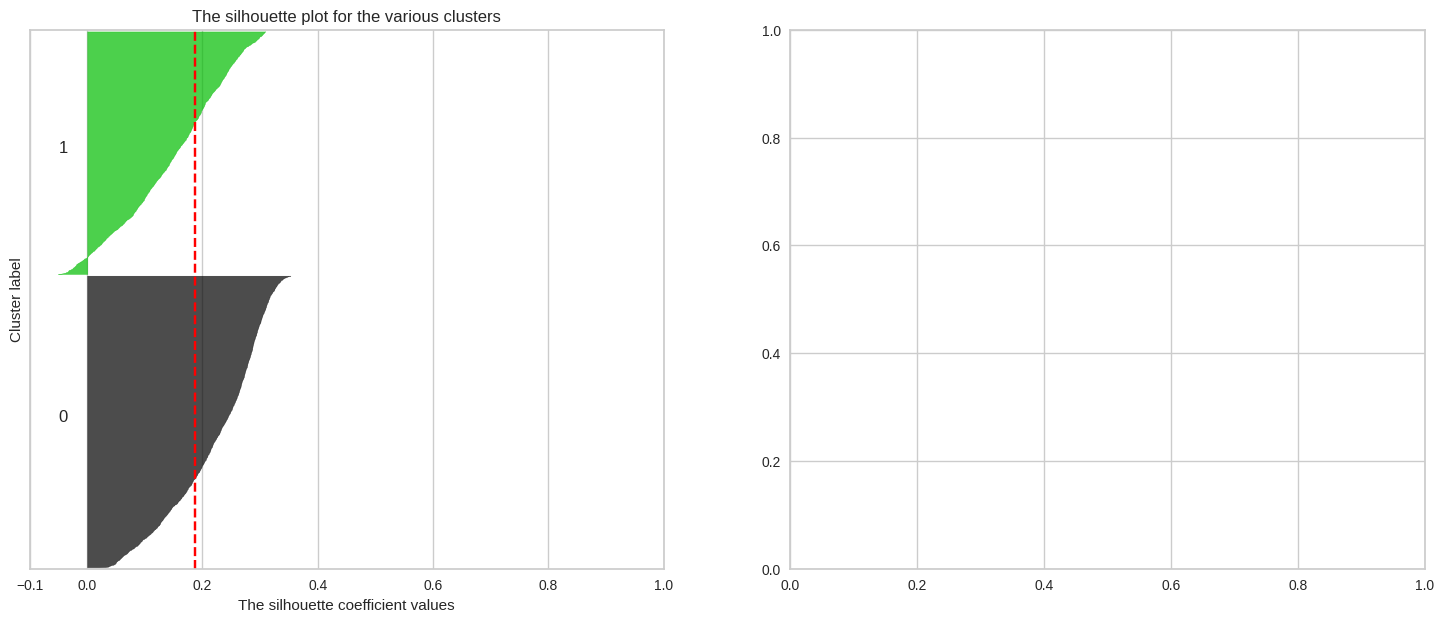

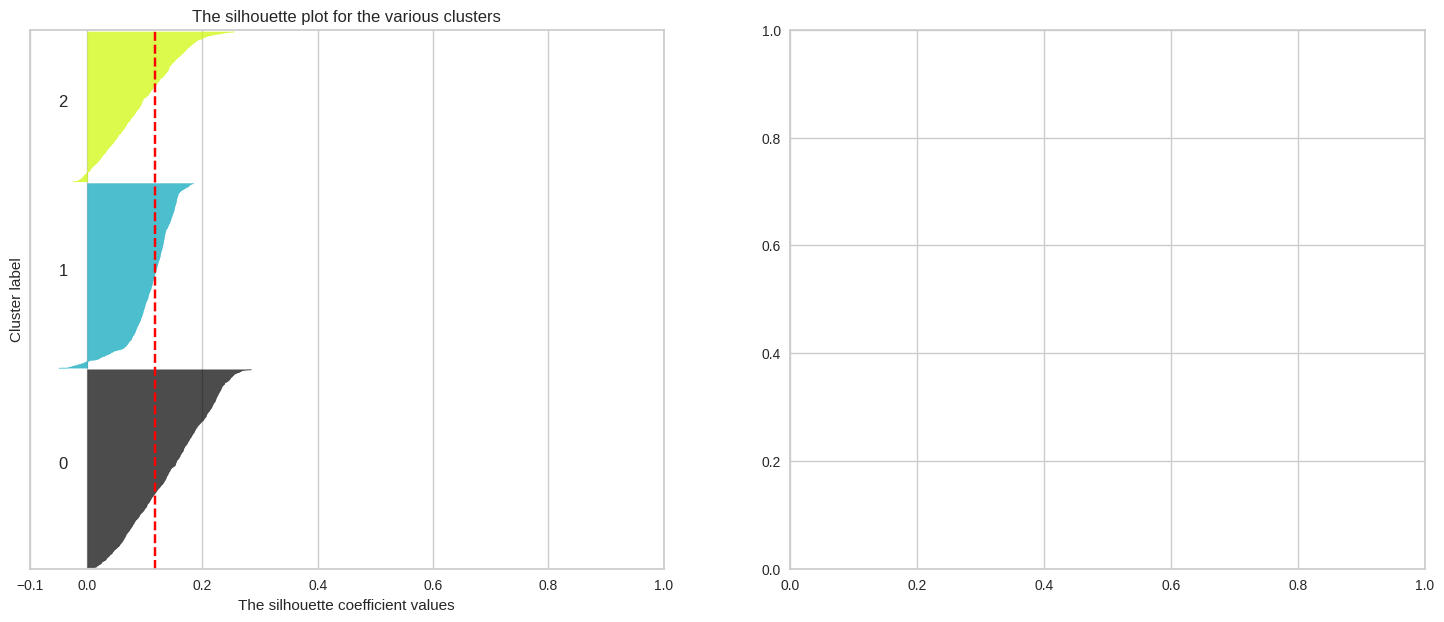

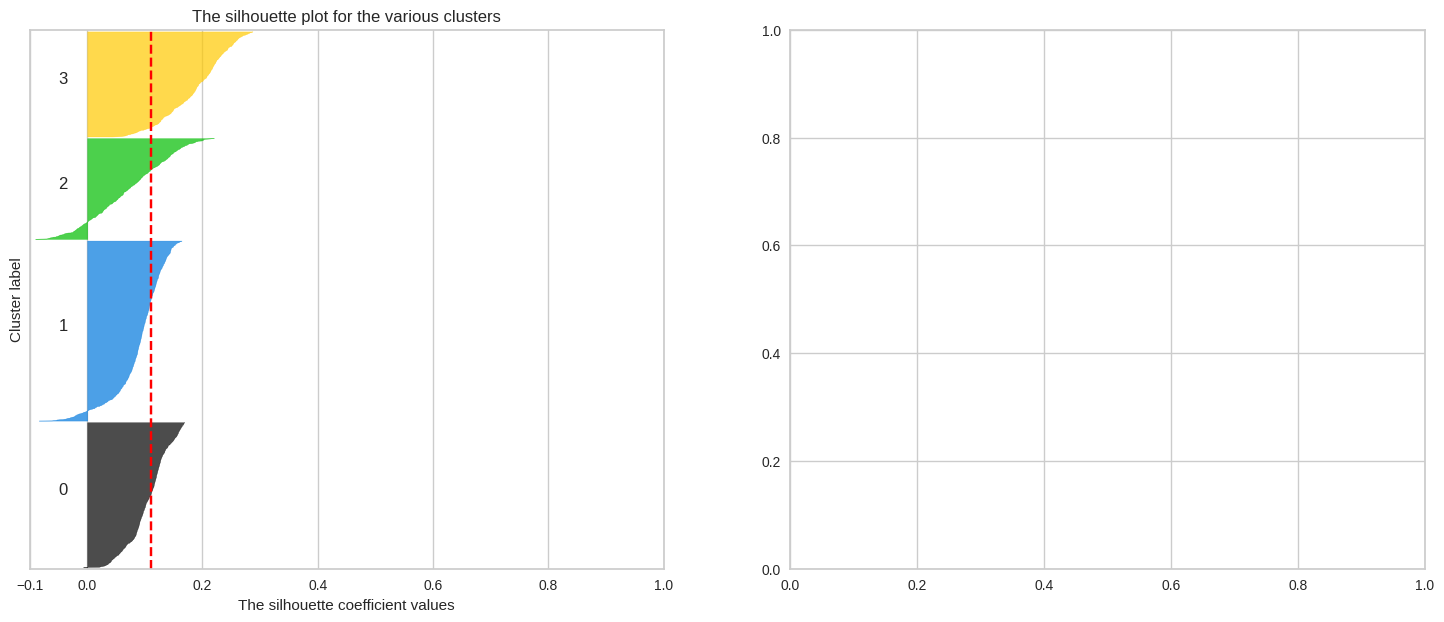

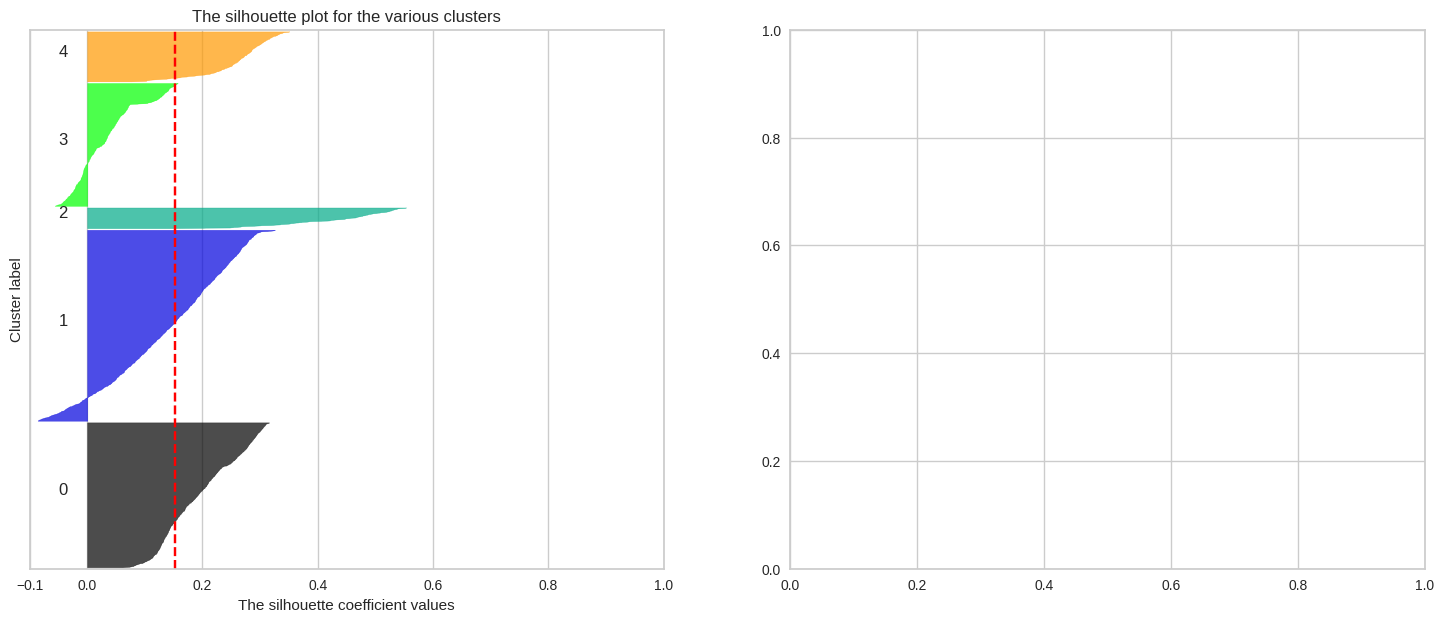

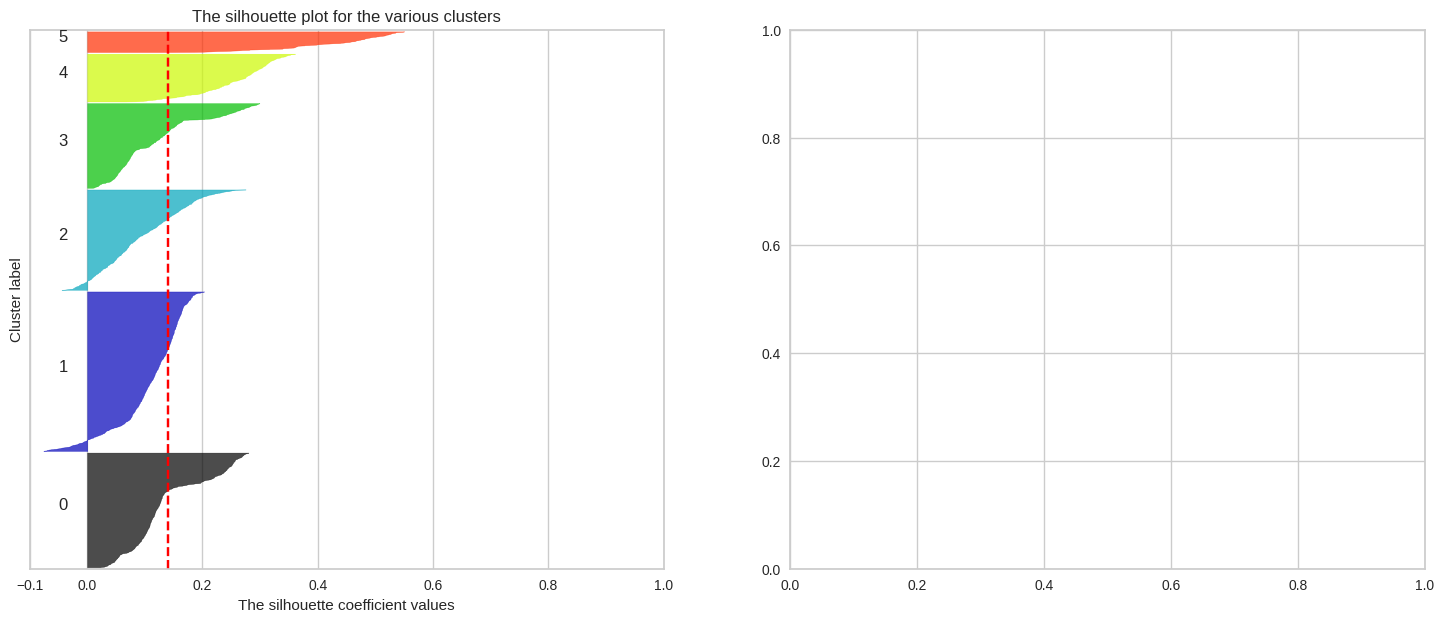

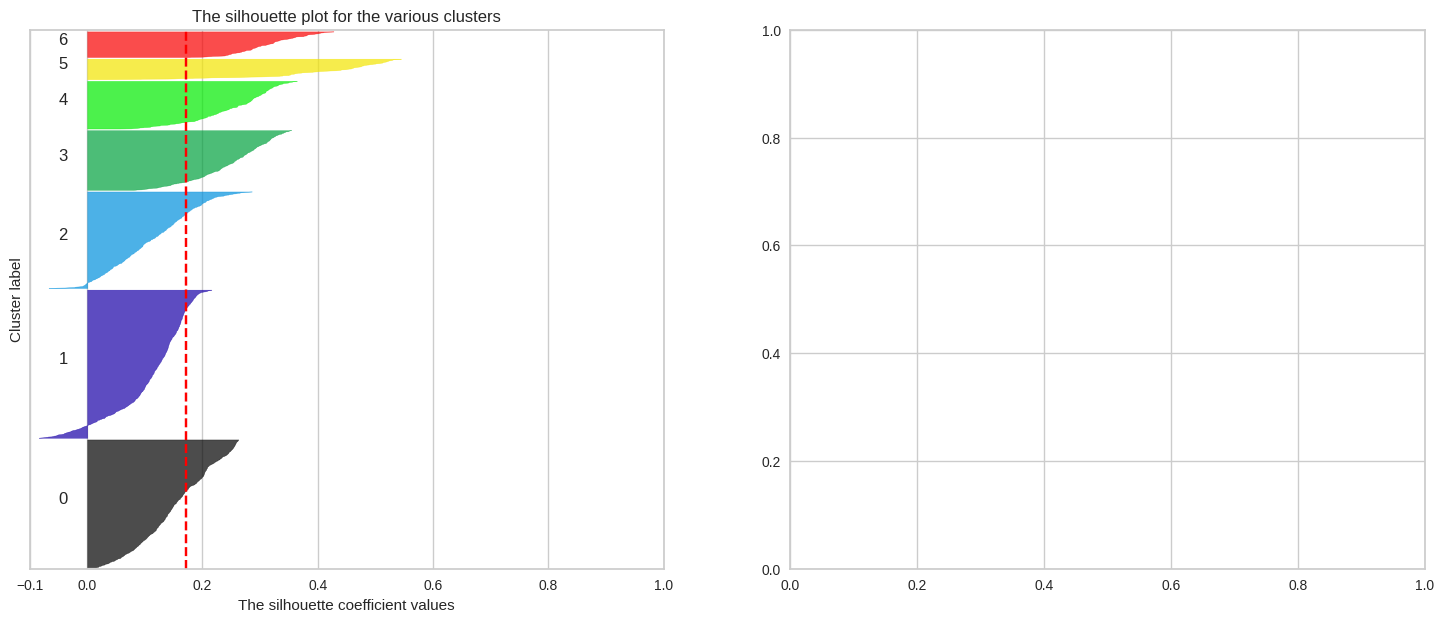

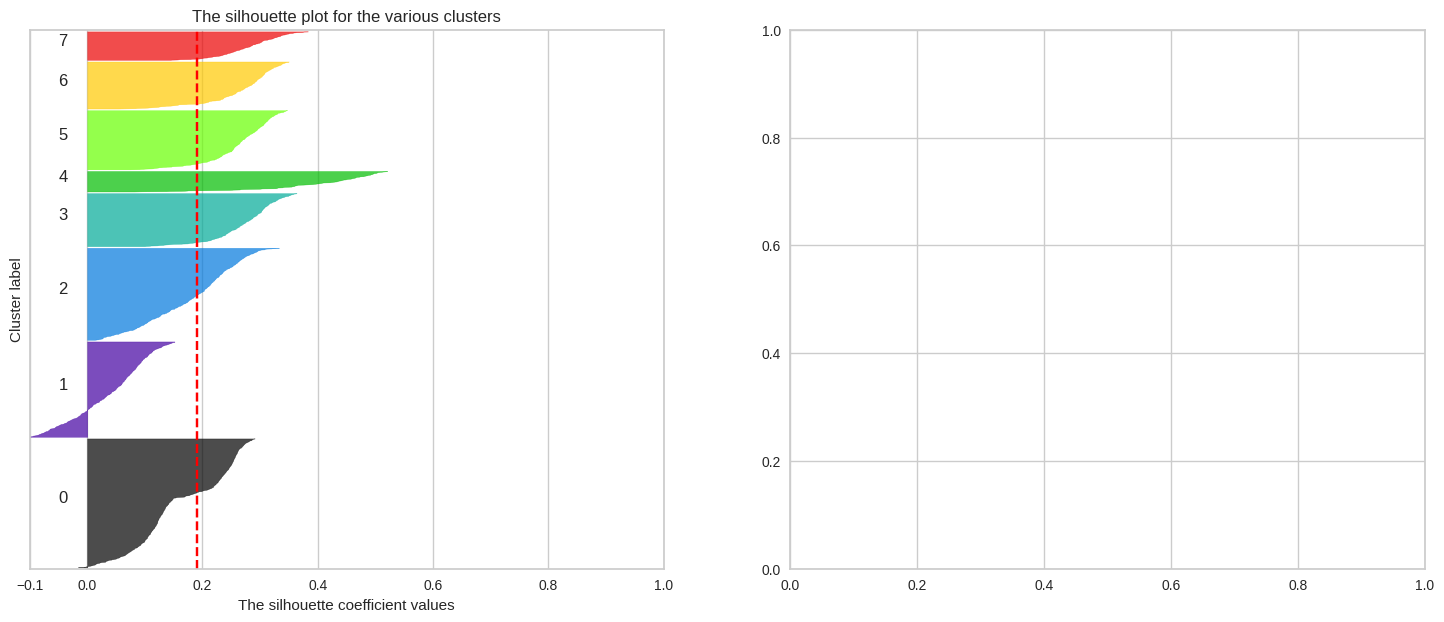

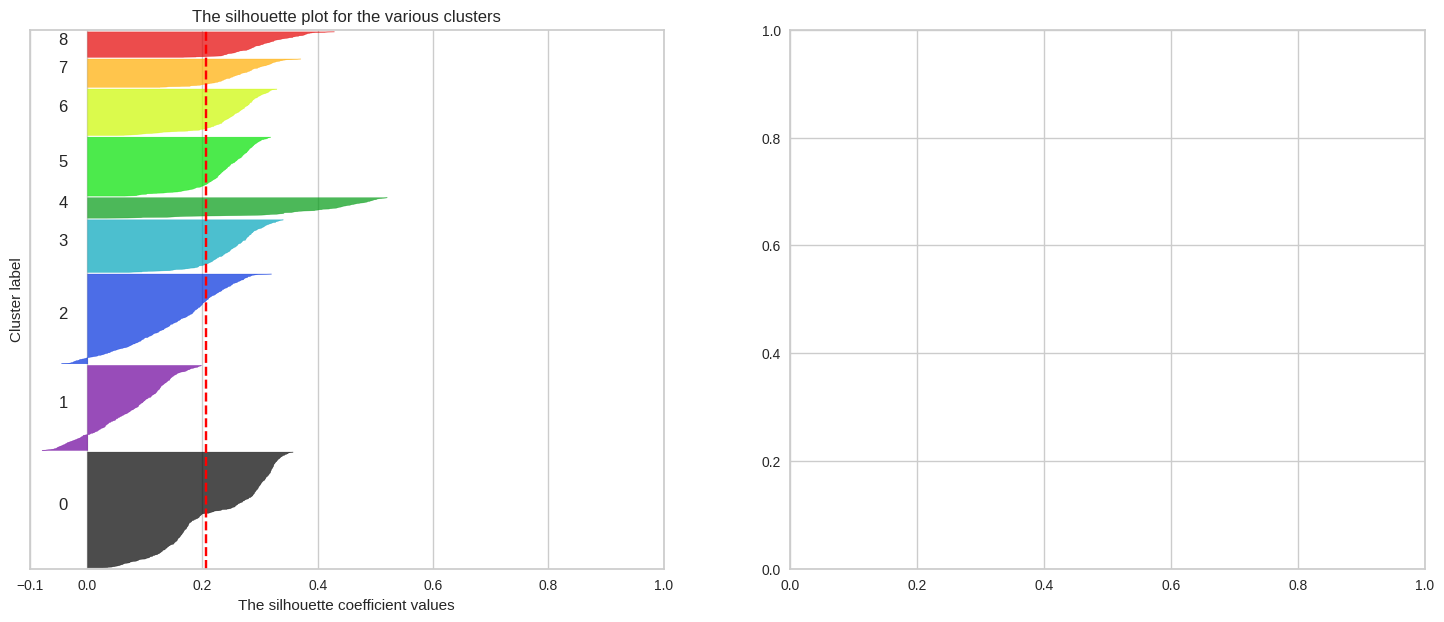

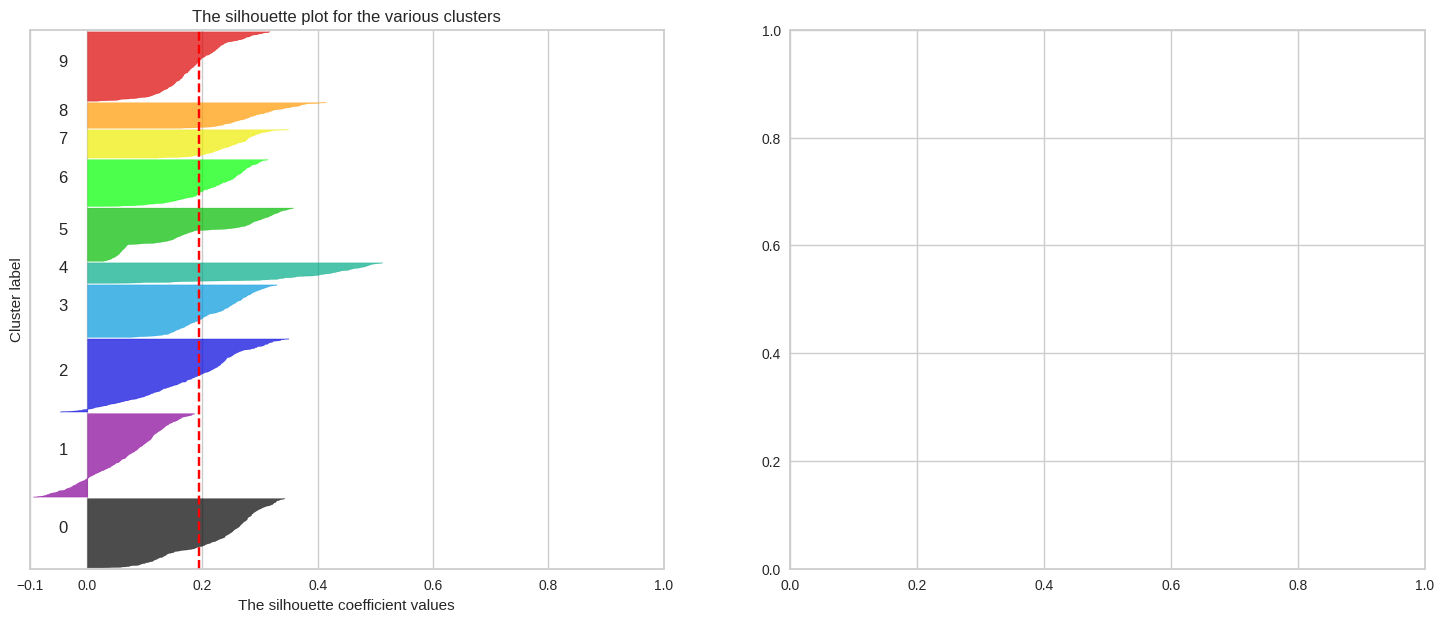

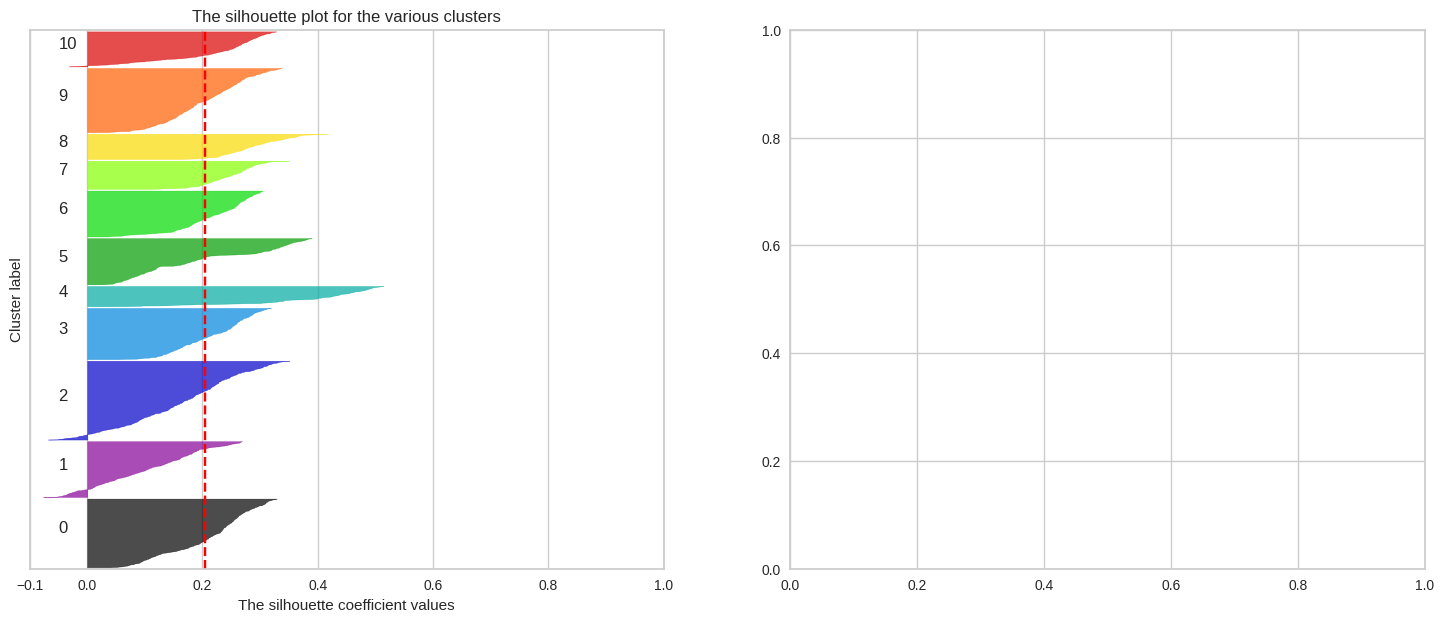

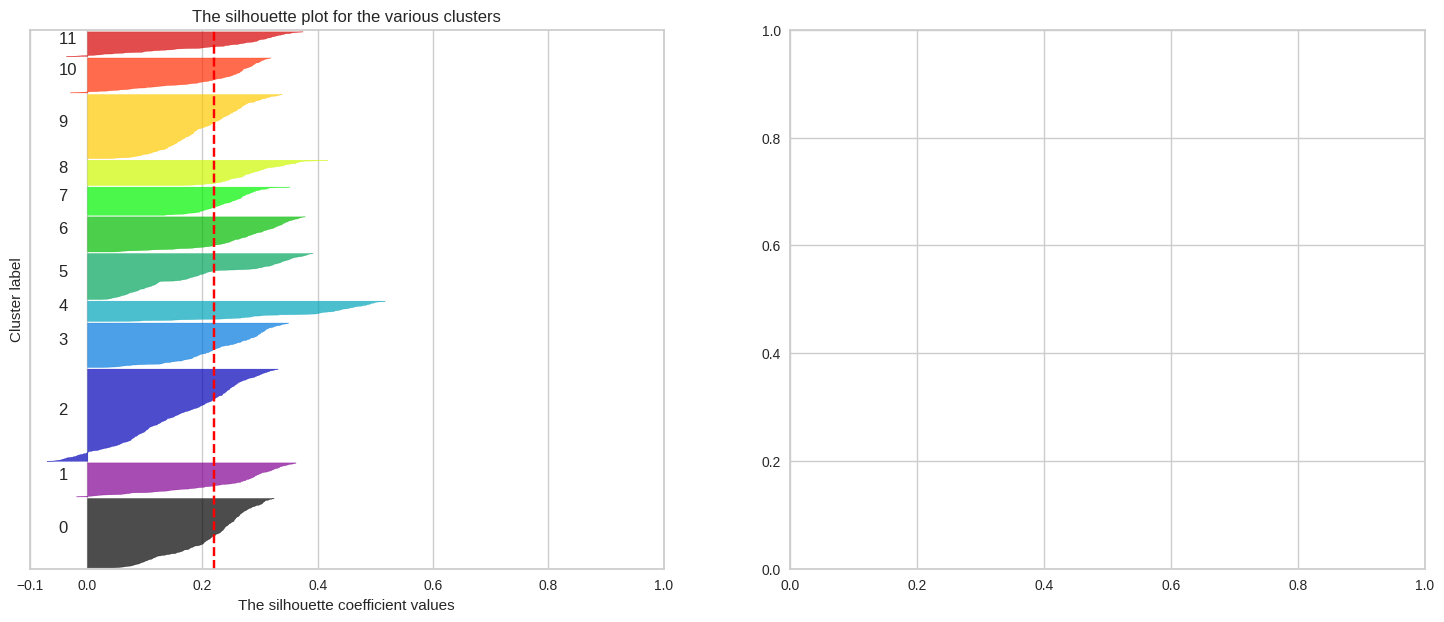

In [20]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

# Generating the sample data
X = seg_scaled
n_samples, n_features = X.shape
centers = 2
cluster_std = 1

range_n_clusters = [2, 3, 4, 5, 6, 7,8,9,10,11,12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1 to 1, but in this example, all
    # values lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for the average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the y-axis labels/ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd plot showing the actual clusters formed
    colors = cm

In [21]:
# Initialize and fit the K-means model
#kmeans = KMeans(n_clusters=2, random_state=42)

# Fit model and predict clusters
#yhat = kmeans.fit_predict(seg_scaled)


In [22]:
# Initialize and fit the K-means model
kmeans = KMedoids(n_clusters=9, random_state=42)

# Fit model and predict clusters
yhat = kmeans.fit_predict(seg_scaled)

In [23]:
# create a new column in the scaled dataframe with the cluster labels
seg_scaled = pd.DataFrame(seg_scaled, columns=seg.columns)
seg_scaled["Clusters"] = pd.Series(yhat, index=seg_scaled.index)

In [24]:
# Adding the Clusters feature to the original dataframe.
seg["Clusters"] = seg_scaled["Clusters"]

# Principle Component Analysis

In [25]:
from sklearn.decomposition import PCA

In [26]:
#Initiating PCA to reduce dimentions aka features to 2
pca = PCA(n_components=2)
pca.fit(seg_scaled)
PCA_ds = pd.DataFrame(pca.transform(seg_scaled), columns=(["PC1","PC2"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,3439.0,3.119859e-16,2.703903,-4.799526,-1.278412,-0.258062,2.087808,5.306699
PC2,3439.0,-9.090980e-17,1.946491,-3.931141,-1.847159,0.349856,1.595800,4.229135


In [27]:
PCA_ds["Clusters"] = yhat

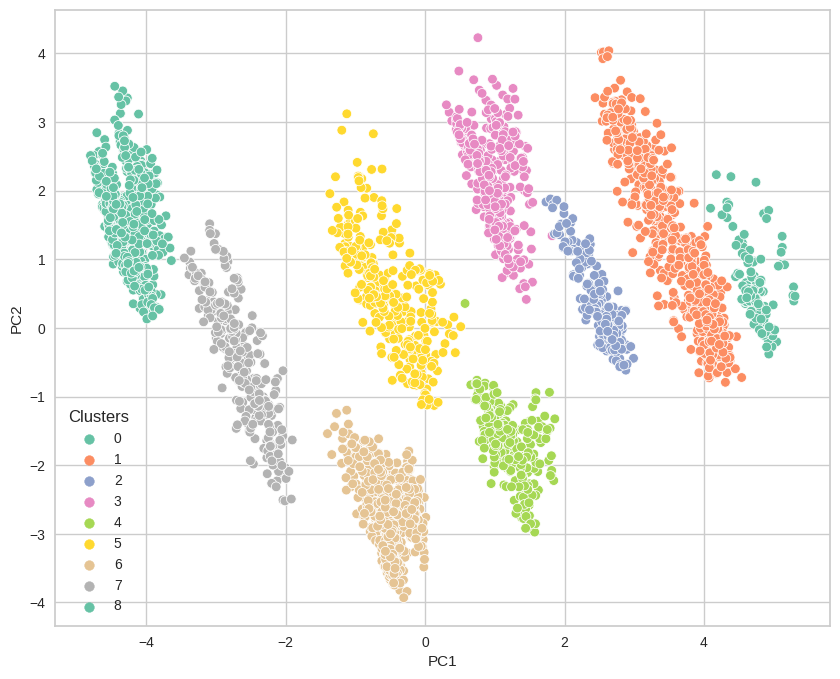

In [44]:
# Plot the clusters on reduced dimension data
plt.figure(figsize=(10,8))
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=PCA_ds, palette="Set2")
plt.show()

In [29]:
seg_reslut=pd.concat([features.iloc[:,0:1],seg], axis=1)

In [30]:
seg_reslut.groupby('Clusters')['CUST_CODE'].nunique()

Clusters
0    125
1    571
2    186
3    362
4    252
5    306
6    783
7    264
8    590
Name: CUST_CODE, dtype: int64

In [31]:
seg_reslut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CUST_CODE             3439 non-null   object 
 1   SPEND                 3439 non-null   float64
 2   frequency             3439 non-null   int64  
 3   total_time            3439 non-null   int64  
 4   mtbp                  3439 non-null   float64
 5   lifetime              3439 non-null   int64  
 6   cltv                  3439 non-null   float64
 7   avg_bskt_spend        3439 non-null   float64
 8   PRICE_SENSITIVITY_LA  3439 non-null   uint8  
 9   PRICE_SENSITIVITY_MM  3439 non-null   uint8  
 10  PRICE_SENSITIVITY_UM  3439 non-null   uint8  
 11  PRICE_SENSITIVITY_XX  3439 non-null   uint8  
 12  LIFESTAGE_OA          3439 non-null   uint8  
 13  LIFESTAGE_OF          3439 non-null   uint8  
 14  LIFESTAGE_OT          3439 non-null   uint8  
 15  LIFESTAGE_PE         

In [32]:
#seg_reslut.to_csv('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer_Cluster_Result.csv', index=False)

# Random Forest

In [33]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [34]:
# Load dataset and split it into features (X) and target variable (y)
X = seg_reslut.drop(columns=['CUST_CODE',
                             'Clusters',])
y = seg_reslut['Clusters']

In [35]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.934593023255814


In [37]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

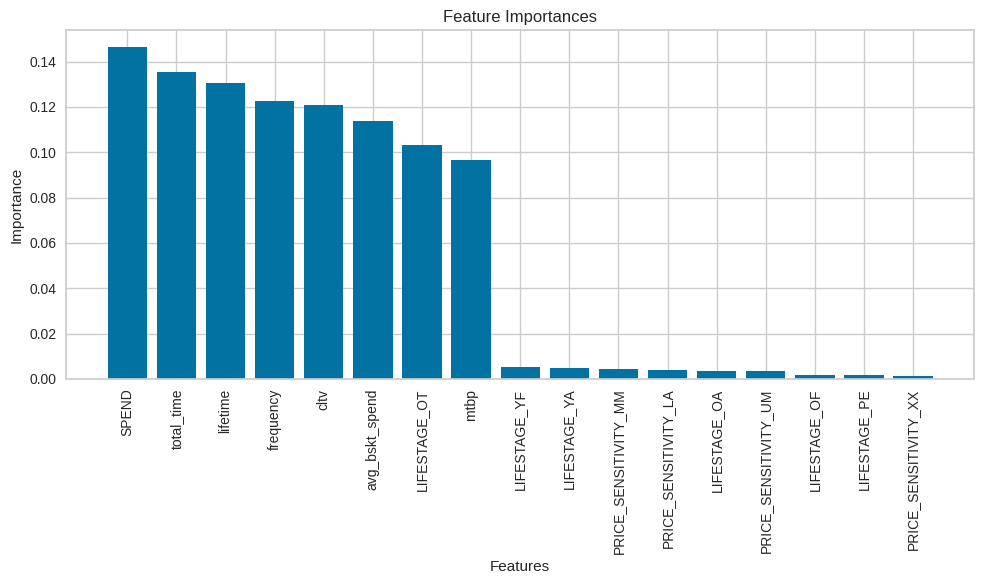

In [38]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Grouping Customer

In [39]:
seg_importance=pd.concat([seg_reslut['SPEND'],
                          seg_reslut['total_time'],
                          seg_reslut['lifetime'],
                          seg_reslut['frequency'],
                          seg_reslut['cltv'],
                          seg_reslut['avg_bskt_spend'],
                          seg_reslut['LIFESTAGE_OT'],
                          seg_reslut['mtbp'],
                          seg_reslut['Clusters']], axis=1)

In [40]:
gp=[]
for i in range(0,seg_importance['Clusters'].max()+1):
  gp.append(seg_importance[seg_importance['Clusters']==i].reset_index(drop=True))


#gp1=seg_importance[seg_importance['Clusters']==0].reset_index(drop=True)
#gp2=seg_importance[seg_importance['Clusters']==1].reset_index(drop=True)
#gp3=seg_importance[seg_importance['Clusters']==2].reset_index(drop=True)
#gp4=seg_importance[seg_importance['Clusters']==3].reset_index(drop=True)
#gp5=seg_importance[seg_importance['Clusters']==4].reset_index(drop=True)

In [41]:
gp_info=[]
for i in range(0,seg_importance['Clusters'].max()+1):
  gp_info.append([])
  gp_info[i].append(gp[i]['SPEND'].mean())
  gp_info[i].append(gp[i]['total_time'].mean())
  gp_info[i].append(gp[i]['lifetime'].mean())
  gp_info[i].append(gp[i]['frequency'].mean())
  gp_info[i].append(gp[i]['cltv'].mean())
  gp_info[i].append(gp[i]['avg_bskt_spend'].mean())
  gp_info[i].append(gp[i]['LIFESTAGE_OT'].mean())
  gp_info[i].append(gp[i]['mtbp'].mean())

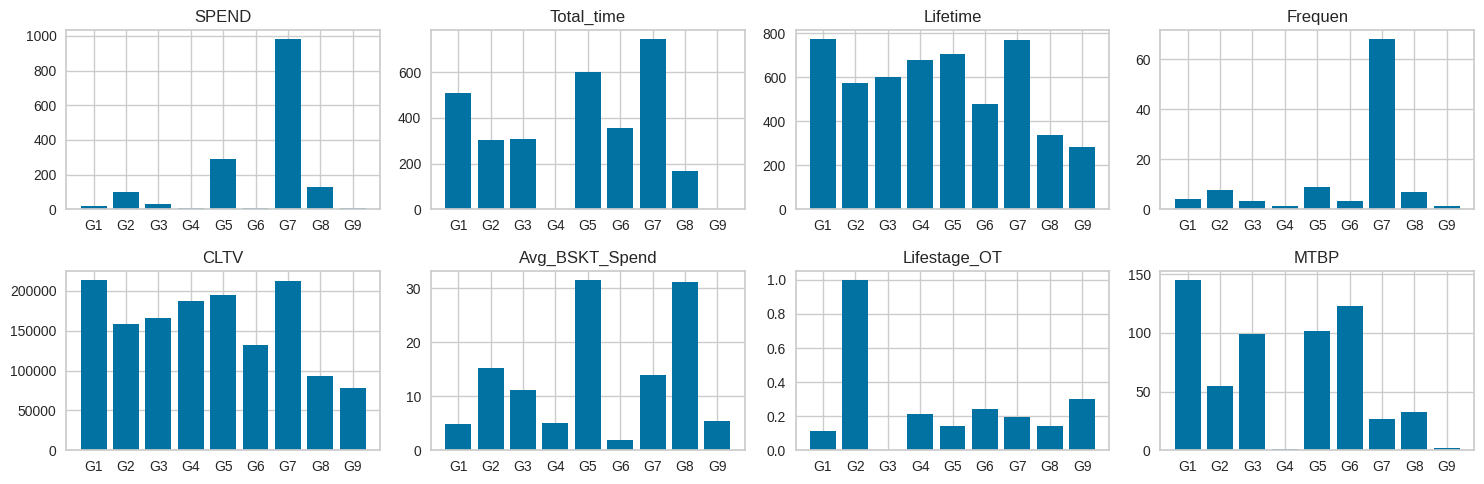

In [42]:
# creating the dataset

para=['G1','G2','G3','G4','G5','G6','G7','G8','G9']

SPEND=[]
Total_time=[]
Lifetime=[]
Frequen=[]
CLTV=[]
Avg_BSKT_Spend=[]
Lifestage_OT=[]
MTBP=[]

for i in range(len(gp_info)):
  SPEND.append(gp_info[i][0])
  Total_time.append(gp_info[i][1])
  Lifetime.append(gp_info[i][2])
  Frequen.append(gp_info[i][3])
  CLTV.append(gp_info[i][4])
  Avg_BSKT_Spend.append(gp_info[i][5])
  Lifestage_OT.append(gp_info[i][6])
  MTBP.append(gp_info[i][7])

# Set up the subplots with 1 row and 5 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 5))

# Plot the first bar chart
axs[0,0].bar(para, SPEND)
axs[0,0].set_title('SPEND')

# Plot the second bar chart
axs[0,1].bar(para, Total_time)
axs[0,1].set_title('Total_time')

# Plot the third bar chart
axs[0,2].bar(para, Lifetime)
axs[0,2].set_title('Lifetime')

# Plot the fourth bar chart
axs[0,3].bar(para, Frequen)
axs[0,3].set_title('Frequen')

# Plot the fourth bar chart
axs[1,0].bar(para, CLTV)
axs[1,0].set_title('CLTV')

# Plot the fourth bar chart
axs[1,1].bar(para, Avg_BSKT_Spend)
axs[1,1].set_title('Avg_BSKT_Spend')

# Plot the fourth bar chart
axs[1,2].bar(para, Lifestage_OT)
axs[1,2].set_title('Lifestage_OT')

# Plot the fourth bar chart
axs[1,3].bar(para, MTBP)
axs[1,3].set_title('MTBP')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()